# 2. EDA on the ML dataset

This notebook contians the exploratory data analysis on the films dataset.

Using the CPI data, we can adjust the budget and revenue into real dollars. Use this equation:

$x_{t_f} = x_{t_f} \big( CPI_{t_f} ÷ CPI_{t_s} \big)$

where $x_{t_f}$ is the dollar amount now, $x_{t_s}$ is the dollar amount at the release date, $CPI_{t_f}$ is the Consumer Price Index now and $CPI_{t_s}$ is the Consumer Price Index at the release date.

In [115]:
# for the sake of development, use this magic command to solve slow suggestion
%config Completer.use_jedi = False

In [116]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 150)

On reading in the data, there are some features that will be created. These are

* `profit` and `profit_class`,
* drilling into `release_date` by extracting `year` and `month`,
* `cast_crew_sum_pop` and `cast_crew_product_pop` from the cast and crew popularities.

The budget and revenue is adjusted here as mentioned above.

Several columns are dropped given they do not add any value. These are `id`, `tmdbId`, `popularity` and `year`.

In [117]:
def to_date(x):
    return datetime.strptime(x[:-2]+'01', '%Y-%m-%d')

#
df = pd.read_csv('prod-movies/movies.csv'
                , converters = {'release_date': to_date})
df['profit'] = df['revenue'] - df['budget']
df['profit_class'] = df['profit'].apply(lambda x: 1 if x < 0 else 0)

df['year'] = df['release_date'].dt.year
df['month'] = df['release_date'].dt.strftime('%b')

df.drop(['id','tmdbId','popularity', 'year'], axis=1, inplace=True)

In [118]:
df['cast_crew_sum_pop'] = df['director_pop'] + df['avg_actor_pop'] + df['avg_writer_pop']
df['cast_crew_product_pop'] = df['director_pop'] * df['avg_actor_pop'] * df['avg_writer_pop']

In [119]:
def cpi_adjust(row, CPI_tf):
    """
    Function to adjust the dollar amounts of previous years by the Consumer
    Price Index.
    
    x_tf = x_ts (CPI_tf / CPI_ts)
    
    Args:
    - row: the row of data sent to the function
    - CPI_tf: most recent CPI
    """
    CPI_ts = row['CPIAUCSL']
    x_ts = row.iloc[0]
    
    x_tf = x_ts * (CPI_ts / CPI_tf)
    return x_tf
    

In [120]:
# adjust the revenue and budget to current day values
CPI_tf = df['CPIAUCSL'].max()

df['budget'] = df[['budget', 'CPIAUCSL']].apply(cpi_adjust
                                                , args=(CPI_tf ,), axis=1)
df['revenue'] = df[['revenue', 'CPIAUCSL']].apply(cpi_adjust
                                                  , args=(CPI_tf ,), axis=1)

# no longer need CPI data
df.drop('CPIAUCSL', axis=1, inplace=True)

## EDA - High Level Overview of the Data

### 0.1 Summary statistics of the data

In [121]:
df.describe()

,budget,revenue,runtime,num_prods,num_languages,director_pop,num_writers,avg_writer_pop,max_writer_pop,min_writer_pop,sum_actor_pop,avg_actor_pop,max_actor_pop,min_actor_pop,UNRATE,PCE,profit,profit_class,year,cast_crew_sum_pop,cast_crew_product_pop
count,5.579000e+03,5.579000e+03,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5.579000e+03,5579.000000,5579.000000,5579.000000,5579.000000
mean,2.519240e+07,7.309815e+07,109.991576,3.441477,1.489156,2.121568,2.060047,1.041169,1.979608,1.239822,16.695785,5.565262,8.976599,2.876935,6.118516,8294.883205,6.204823e+07,0.300054,2003.305610,8.727999,21.399272
std,3.458169e+07,1.477052e+08,21.077954,2.291254,0.948484,2.228899,1.458330,1.071556,1.939398,1.362361,10.619324,3.539775,6.716860,2.115103,1.691939,3505.897572,1.468563e+08,0.458322,11.023053,4.990494,87.838710
min,3.546867e-01,3.546867e-01,0.000000,1.000000,1.000000,0.600000,1.000000,0.200000,0.600000,0.600000,0.600000,0.200000,0.600000,0.600000,3.400000,588.700000,-1.657101e+08,0.000000,1969.000000,1.000000,0.024000
25%,4.611265e+06,5.519509e+06,96.000000,2.000000,1.000000,0.884000,1.000000,0.400000,0.828000,0.600000,8.724500,2.908167,4.352000,1.279500,4.800000,5460.200000,-1.846820e+06,0.000000,1997.000000,5.218667,1.564029
50%,1.287304e+07,2.183716e+07,106.000000,3.000000,1.000000,1.428000,2.000000,0.684667,1.400000,0.732000,14.860000,4.953333,7.584000,2.300000,5.600000,9122.100000,1.275659e+07,0.000000,2006.000000,7.676333,4.801679
75%,3.116027e+07,7.555426e+07,120.000000,4.000000,2.000000,2.341000,3.000000,1.263500,2.273000,1.388500,22.387000,7.462333,11.400000,3.899000,7.200000,11004.100000,6.525956e+07,1.000000,2012.000000,11.189000,14.284579
max,3.300606e+08,2.341225e+09,339.000000,26.000000,10.000000,26.885000,24.000000,10.833667,26.885000,17.438000,90.203000,30.067667,43.284000,19.097000,10.800000,14880.500000,2.550965e+09,1.000000,2020.000000,52.876333,4337.711242


<AxesSubplot:title={'center':'Logarithmic budget and revenue distributions'}, xlabel='Log (base 10) of $', ylabel='Count'>

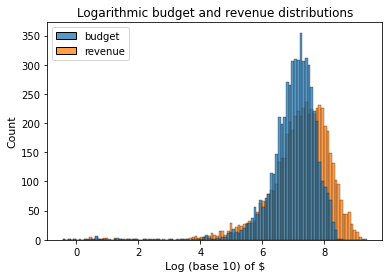

In [122]:
plt.figure(figsize=(6,4))
plt.xlabel('Log (base 10) of $', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Logarithmic budget and revenue distributions'
          , fontdict={'fontsize': 12})
dfCopy = df.copy()
sns.histplot([dfCopy.budget.apply(lambda x: math.log10(x))
              , dfCopy.revenue.apply(lambda x: math.log10(x))])
# sns.despine(right=True)

In [123]:
df[df['runtime']==0].shape

(5, 32)

<AxesSubplot:title={'center':'Logarithmic budget and revenue distributions'}, xlabel='Log (base 10) of $', ylabel='Count'>

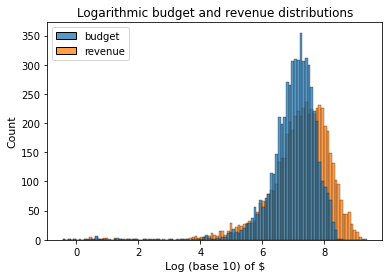

In [126]:
plt.figure(figsize=(6,4))
plt.xlabel('Log (base 10) of $', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Logarithmic budget and revenue distributions'
          , fontdict={'fontsize': 12})
dfCopy = df[df['revenue']<=10000000000].copy()
sns.histplot([dfCopy.budget.apply(lambda x: math.log10(x))
              , dfCopy.revenue.apply(lambda x: math.log10(x))])
# sns.despine(right=True)

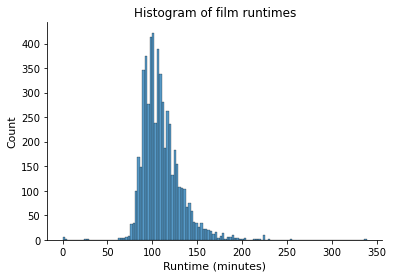

In [8]:
plt.figure(figsize=(6,4))
plt.xlabel('Runtime (minutes)', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Histogram of film runtimes', fontdict={'fontsize': 12})
sns.histplot(df.runtime)
sns.despine(right=True)

**Actionable Insights**:

* Notably, the runtime has a minimum of zero. This is not possible in the use case, and so is dealt with as a null value. The median value will be used to impute these missing values.

* Revenue and budget both have minimum values of 1. I'm sure Hollywood would love \\$1 budgets, and I'm certain they'd hate \\$1 revenues. Investigate the distributions of these features to see if there are rows that should be dropped.


In [9]:
# imputing the runtimes
df.query('runtime == 0')
df['runtime'].replace(to_replace=0, value=df['runtime'].median(), inplace=True)

Investigate the 

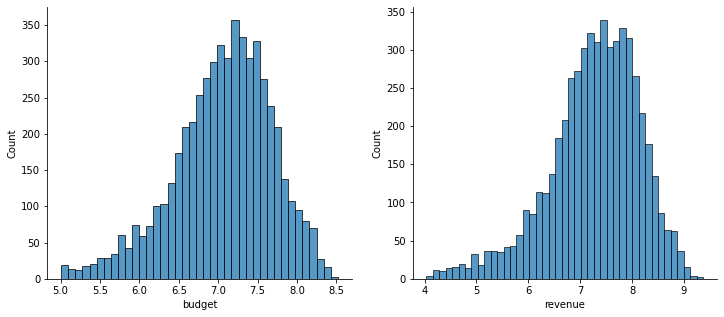

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(df['budget'].apply(math.log10), ax=ax[0])
sns.histplot(df['revenue'].apply(math.log10), ax=ax[1])
sns.despine(right=True)
plt.show()

We see that both features have a very heavy right skew, with long tails. The revenue of the films goes up to $10^9$, with the majority of films earning a revnue below that $1,000,000,000 (billion-dollar) threshold. Outliers on both ends should be investigated.

In [109]:
for thresh in [10**2,10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]:
    print("Films under ${} revenue - {:.2f}%".format(
        thresh, 100*df[df['revenue']<thresh].shape[0]/df.shape[0]
    ))

Films under $100 revenue - 0.65%
Films under $1000 revenue - 0.75%
Films under $10000 revenue - 1.20%
Films under $100000 revenue - 3.28%
Films under $1000000 revenue - 9.98%
Films under $10000000 revenue - 34.95%
Films under $100000000 revenue - 80.68%
Films under $1000000000 revenue - 99.61%
Films under $10000000000 revenue - 100.00%


The above output and figures should it would be wise to drop the 0.65% of films that earnt over a billion dollars in revenue, as well as the 1.08% that earnt below $10,000. Then investigate the distributions again.

In [127]:
df = df.query('10000 <= revenue')

Better! Now look at the budgets.

In [112]:
for thresh in [10**2,10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9]:
    print("Films under ${} budget - {:.2f}%".format(
        thresh, 100*df[df['budget']<thresh].shape[0]/df.shape[0]
    ))

Films under $100 budget - 0.07%
Films under $1000 budget - 0.07%
Films under $10000 budget - 0.20%
Films under $100000 budget - 1.06%
Films under $1000000 budget - 7.47%
Films under $10000000 budget - 42.81%
Films under $100000000 budget - 95.56%
Films under $1000000000 budget - 100.00%


In a similar way, removing the bottom 0.57% will focus the data where the bulk is.

In [130]:
df = df.query('100000 <= budget')

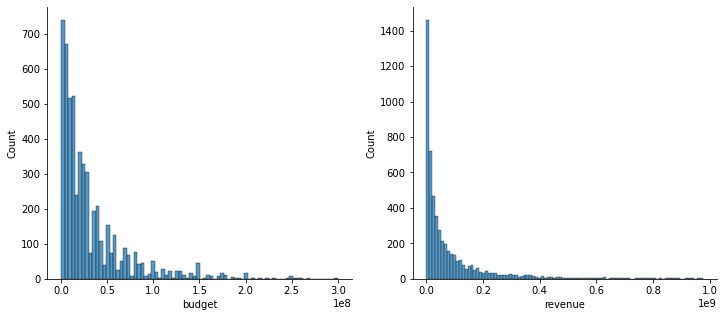

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(df['budget'], ax=ax[0])
sns.histplot(df['revenue'], ax=ax[1])
sns.despine(right=True)
plt.show()

<AxesSubplot:title={'center':'Logarithmic budget and revenue distributions'}, xlabel='Log (base 10) of $', ylabel='Count'>

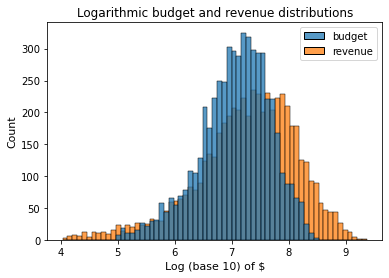

In [135]:
plt.figure(figsize=(6,4))
plt.xlabel('Log (base 10) of $', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Logarithmic budget and revenue distributions'
          , fontdict={'fontsize': 12})
dfCopy = df.copy()
sns.histplot([dfCopy.budget.apply(lambda x: math.log10(x))
              , dfCopy.revenue.apply(lambda x: math.log10(x))])
# sns.despine(right=True)

### 0.2 Feature correlations

Seaborn has a useful heatmap funcitonality that can provide good visual insights into the correlations between variables. The red squares have a strong positive correlation. The lighter colours have no correlation. Darker blue means a stronger negative correlation.

<AxesSubplot:title={'center':'Heatmap of feature correlations'}>

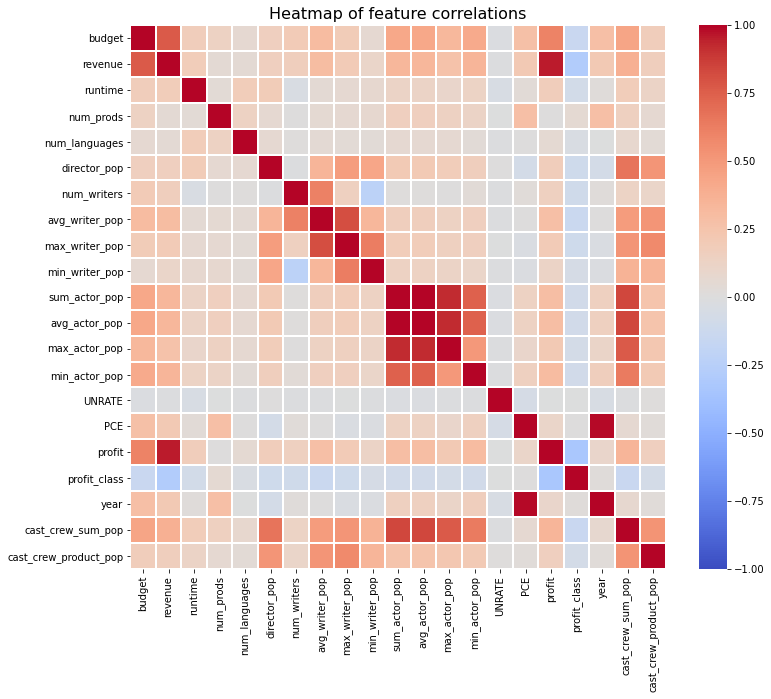

In [136]:
# fig, ax = plt.subplots(figsize=(12,10))

plt.figure(figsize=(12,10))
plt.title('Heatmap of feature correlations', fontdict={'fontsize':16})
sns.heatmap(df.corr(), linewidths=1, cmap='coolwarm', vmin=-1, vmax=1)

<AxesSubplot:title={'center':'Heatmap of feature correlations'}>

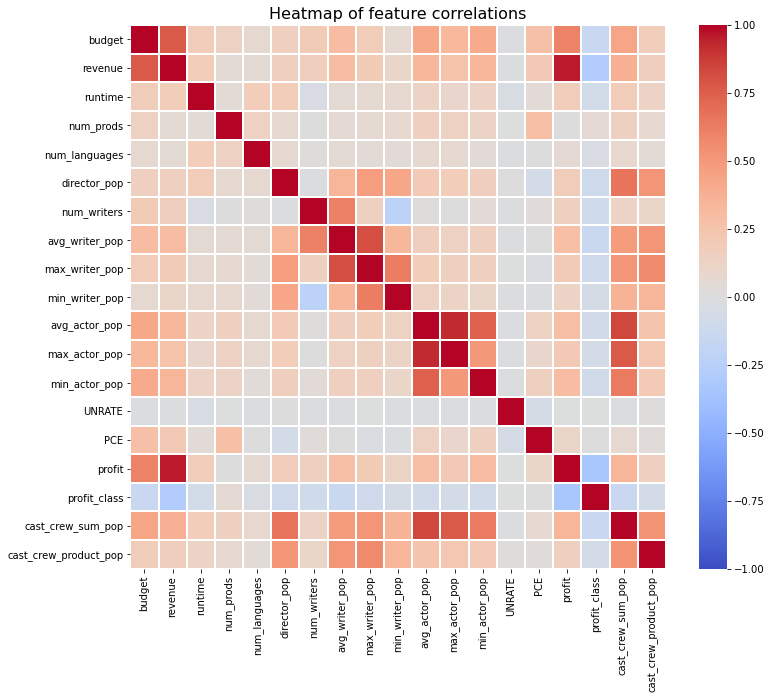

In [138]:
# fig, ax = plt.subplots(figsize=(12,10))

plt.figure(figsize=(12,10))
plt.title('Heatmap of feature correlations', fontdict={'fontsize':16})
sns.heatmap(df.corr(), linewidths=1, cmap='coolwarm', vmin=-1, vmax=1)

The plot below shows that a lot of the data is uncorrelated. There are strong correlations for each of the actor features.

**Actionable Insights**:

* `sum_actor_pop` is directly correlated with `avg_actor_pop`. Drop the former. **DROP ALL HIGHLY CORRELATED FEATURES**.
* drop `year` as it is highly correlated with two of the macroeconomic features
* 

In [137]:
df.drop(['year', 'sum_actor_pop'], axis=1, inplace=True)

### 0.3 Investigate the distributions of some of the features

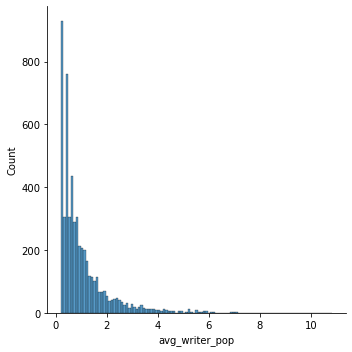

In [23]:
sns.displot(df['avg_writer_pop'])

In [24]:
df['avg_writer_pop'].value_counts().sort_values(ascending=False).head(10)

0.200000    595
0.400000    254
0.466667    111
0.326667     65
0.600000     60
0.280000     51
0.666667     43
0.526667     39
0.653333     36
0.460000     33
Name: avg_writer_pop, dtype: int64

A lot of the features have a very large right skew. We may either discount outliers or apply a logarithm to the features and explore how that effects their distribution.

##### Applying a logarithm to highly skewed features

In [25]:
dfLogarithm = df.copy()
dfLogarithm['log10_avg_writer_pop'] = dfLogarithm['avg_writer_pop'].apply(
    lambda x: math.log10(x)
)

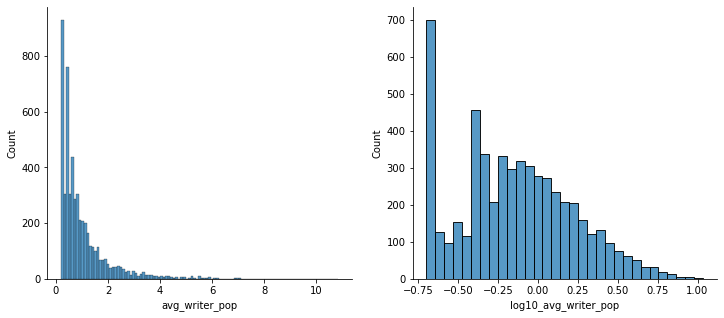

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(dfLogarithm['avg_writer_pop'], ax=ax[0])
sns.histplot(dfLogarithm['log10_avg_writer_pop'], ax=ax[1])
sns.despine(right=True)
plt.show()

Much better! Applying $log_{10}(x)$ to the feature made it a much more normal distribution. However, the huge tally in the first bucket remains. The values should not be discounted given they total over 700.

Now compare how other features behave with a logarithm applied to them.

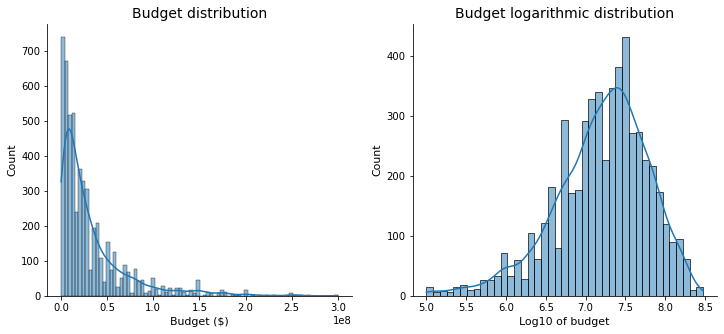

In [35]:
col='budget'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
dfLogarithm = df.copy()
dfLogarithm['log10_'+col] = dfLogarithm[col].apply(
    lambda x: math.log10(x)
)
ax[0].set_title('Budget distribution', fontdict={'fontsize': 14})
ax[0].set_xlabel('Budget ($)', fontdict={'fontsize': 11})
ax[0].set_ylabel('Count', fontdict={'fontsize':11})
sns.histplot(dfLogarithm[col], kde=True, ax=ax[0])


ax[1].set_title('Budget logarithmic distribution', fontdict={'fontsize': 14})
ax[1].set_xlabel('Log10 of budget', fontdict={'fontsize': 11})
ax[1].set_ylabel('Count', fontdict={'fontsize':11})
sns.histplot(dfLogarithm['log10_'+col], kde=True, ax=ax[1])
sns.despine(right=True)
plt.show()

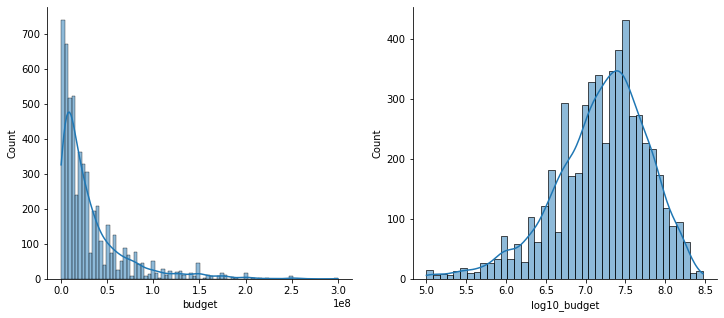

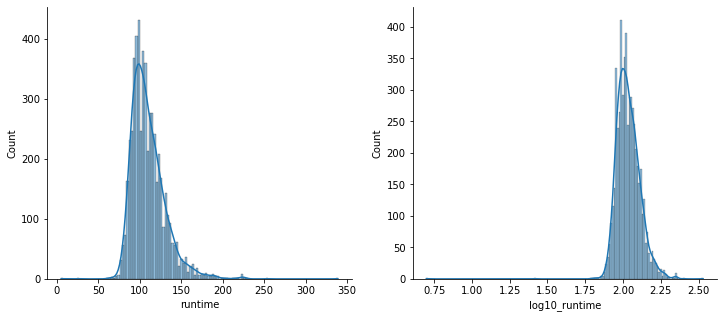

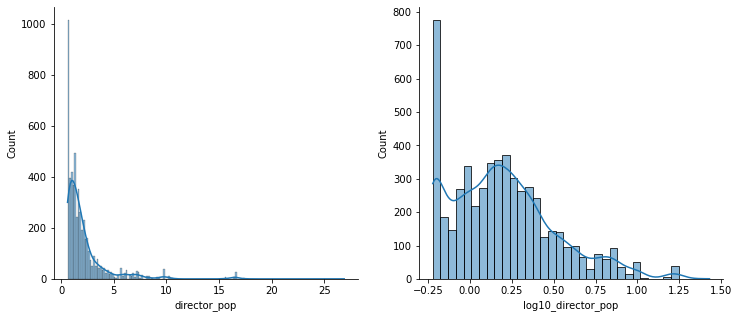

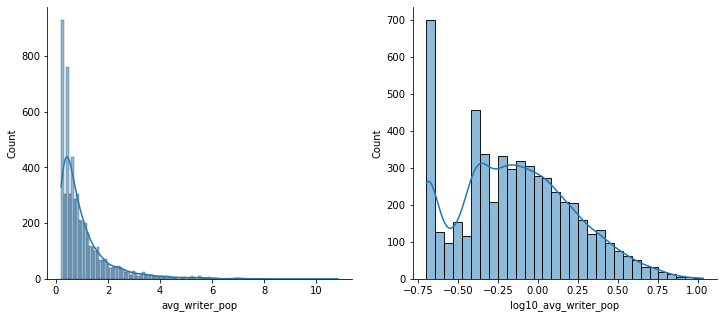

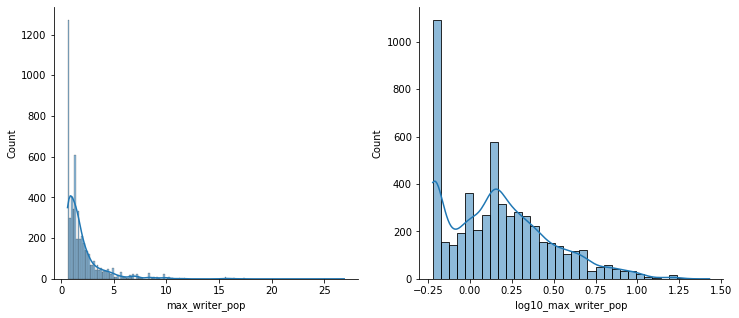

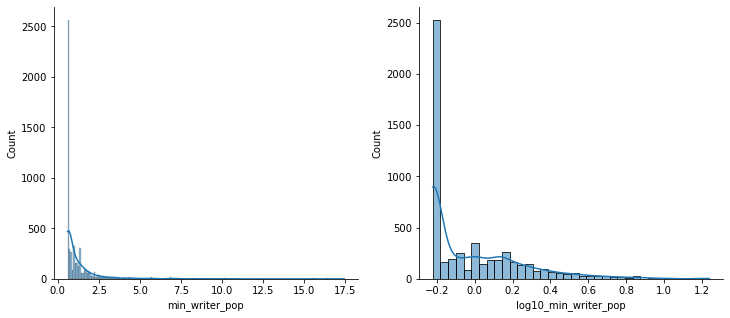

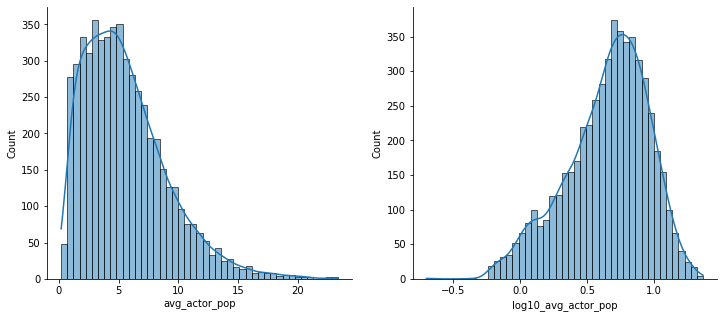

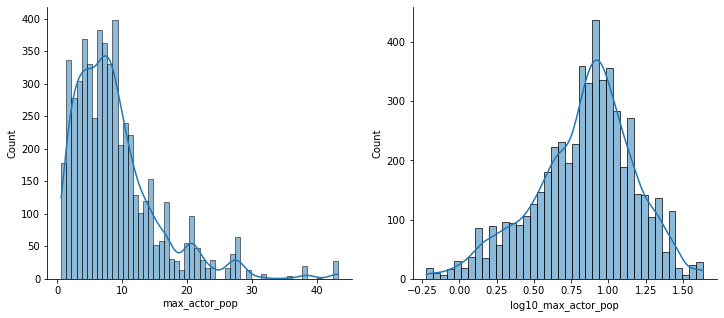

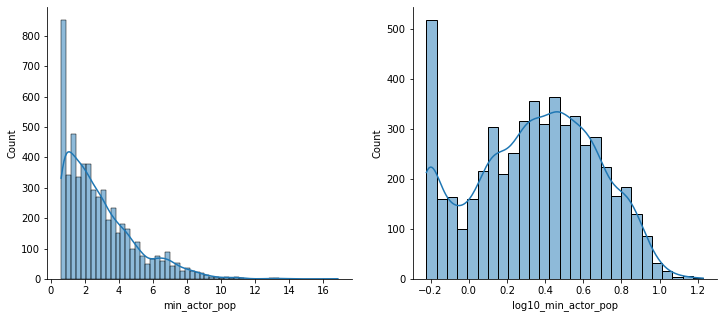

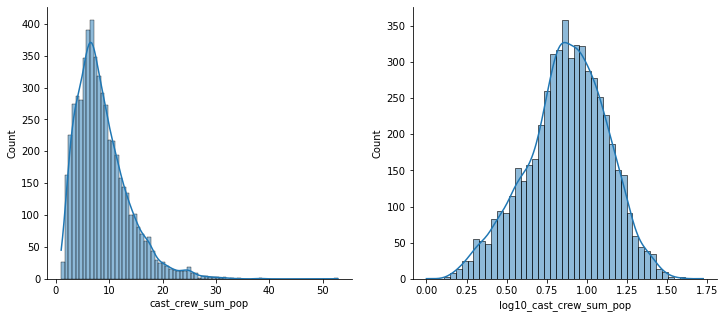

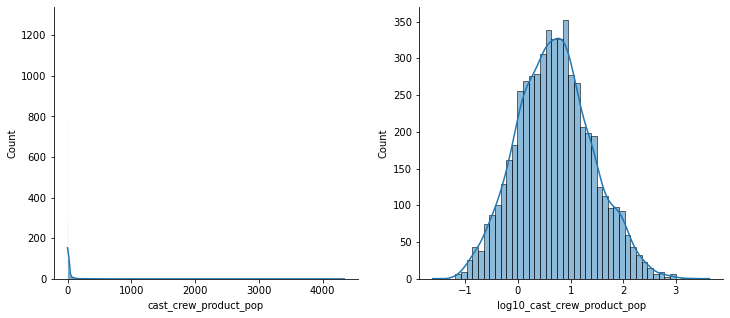

In [37]:
for col in [
    "budget", "runtime", "director_pop", "avg_writer_pop"
    , "max_writer_pop", "min_writer_pop", "avg_actor_pop"
    , "max_actor_pop", "min_actor_pop", 'cast_crew_sum_pop'
    , 'cast_crew_product_pop'
]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    dfLogarithm = df.copy()
    dfLogarithm['log10_'+col] = dfLogarithm[col].apply(
        lambda x: math.log10(x)
    )
    sns.histplot(dfLogarithm[col], kde=True, ax=ax[0])
    sns.histplot(dfLogarithm['log10_'+col], kde=True, ax=ax[1])
    sns.despine(right=True)
    plt.show()

**Actionable insights**: Of the columns, only `runtime` is not improved by the logarithm transform. The column `min_writer_pop` is not improved enough to appear very usable. This feature will be dropped.

Each of the remaining columns (apart from `runtime`) investigated here shall have a logarithm applied to them in the data preprocessing so the machine learning algorithm has data closer to a normal distribution to work with.

In [23]:
df.drop('min_writer_pop', axis=1, inplace=True)

# code to transform columns
for col in [
    "budget", "runtime", "director_pop", "avg_writer_pop"
    , "max_writer_pop", "avg_actor_pop", "max_actor_pop"
    , "min_actor_pop", 'cast_crew_sum_pop'
    , 'cast_crew_product_pop'
]:
    df['log10_'+col] = df[col].apply(lambda x: math.log10(x))
    df.drop(col, axis=1, inplace=True)

In [24]:
df.describe()

,revenue,num_prods,num_languages,num_writers,UNRATE,PCE,CPIAUCSL,profit,profit_class,year,log10_budget,log10_runtime,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
count,5.452000e+03,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5.452000e+03,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5452.000000,5.452000e+03,5452.000000
mean,8.801538e+07,3.451027,1.491196,2.060161,6.119296,8284.958969,187.975899,5.602430e+07,0.298789,2003.281548,7.202729,2.034816,0.193595,-0.145122,0.168098,0.651041,0.837650,0.345209,8.728495e-01,0.699514
std,1.414698e+08,2.293616,0.949522,1.457920,1.689777,3499.812689,49.285630,1.169183e+08,0.457769,11.001032,0.586308,0.077462,0.311753,0.363477,0.309689,0.307234,0.336292,0.323845,2.494340e-01,0.711322
min,1.001800e+04,1.000000,1.000000,1.000000,3.400000,588.700000,35.800000,-1.657101e+08,0.000000,1969.000000,5.000000,0.698970,-0.221849,-0.698970,-0.221849,-0.698970,-0.221849,-0.221849,-9.643275e-17,-1.619789
25%,9.323598e+06,2.000000,1.000000,1.000000,4.800000,5459.975000,159.900000,-1.941839e+06,0.000000,1997.000000,6.845098,1.982271,-0.048177,-0.397940,-0.081970,0.466868,0.639885,0.111766,7.202420e-01,0.196873
50%,3.338630e+07,3.000000,1.000000,2.000000,5.600000,9122.100000,199.700000,1.288389e+07,0.000000,2006.000000,7.278754,2.025306,0.155032,-0.164944,0.146128,0.695948,0.881556,0.362482,8.854649e-01,0.683702
75%,1.008555e+08,4.000000,2.000000,3.000000,7.200000,11004.100000,229.918000,6.457974e+07,1.000000,2012.000000,7.602060,2.079181,0.366983,0.100141,0.354876,0.873035,1.056905,0.590061,1.048697e+00,1.152662
max,9.764756e+08,26.000000,10.000000,24.000000,10.800000,14880.500000,258.820000,8.947619e+08,1.000000,2020.000000,8.477121,2.530200,1.429510,1.034775,1.429510,1.367958,1.636327,1.227578,1.723261e+00,3.637261


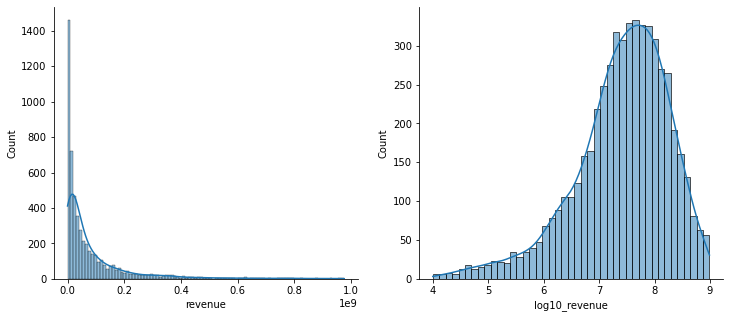

In [25]:
col='revenue'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
dfLogarithm = df.copy()
dfLogarithm['log10_'+col] = dfLogarithm[col].apply(
    lambda x: math.log10(x)
)
sns.histplot(dfLogarithm[col], kde=True, ax=ax[0])
sns.histplot(dfLogarithm['log10_'+col], kde=True, ax=ax[1])
sns.despine(right=True)
plt.show()

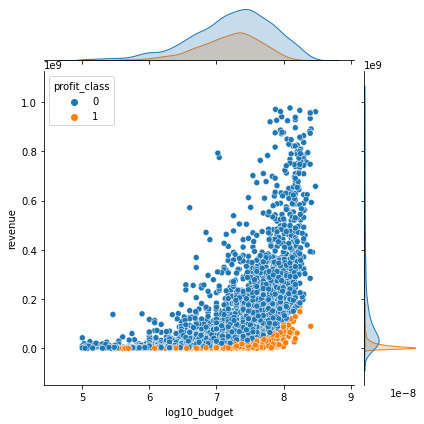

In [26]:
sns.jointplot(x=df['log10_budget'], y=df['revenue'], hue=df['profit_class'])

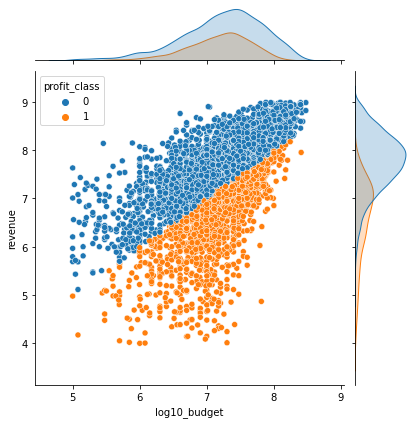

In [27]:
# do the same but the logarithm of revenue
sns.jointplot(
    x=df['log10_budget']
    , y=df['revenue'].apply(lambda x: math.log10(x))
    , hue=df['profit_class']
)

As we expect, the relationships is very clear to see. The bottom right is all the films were the budget exceeded the revenue, i.e., the film lost money. The top right is where the revenue exceeded the budget, i.e., the film made money.

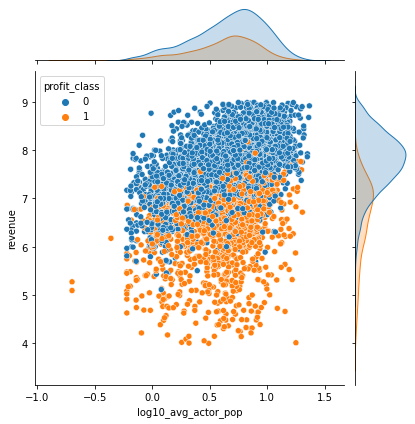

In [28]:
# do the same but the logarithm of revenue
sns.jointplot(
    x=df['log10_avg_actor_pop']
    , y=df['revenue'].apply(lambda x: math.log10(x))
    , hue=df['profit_class']
)

In [29]:
df['log10_revenue'] = df['revenue'].apply(lambda x: math.log10(x))

In [30]:
df.describe().columns

Index(['revenue', 'num_prods', 'num_languages', 'num_writers', 'UNRATE', 'PCE',
       'CPIAUCSL', 'profit', 'profit_class', 'year', 'log10_budget',
       'log10_runtime', 'log10_director_pop', 'log10_avg_writer_pop',
       'log10_max_writer_pop', 'log10_avg_actor_pop', 'log10_max_actor_pop',
       'log10_min_actor_pop', 'log10_cast_crew_sum_pop',
       'log10_cast_crew_product_pop', 'log10_revenue'],
      dtype='object')

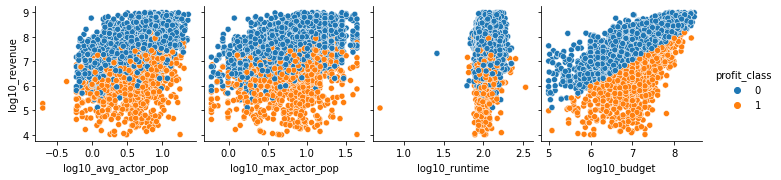

In [31]:
sns.pairplot(
    data=df
    , y_vars = 'log10_revenue'
    , x_vars = ['log10_avg_actor_pop', 'log10_max_actor_pop', 'log10_runtime', 'log10_budget']
    , hue='profit_class'
)

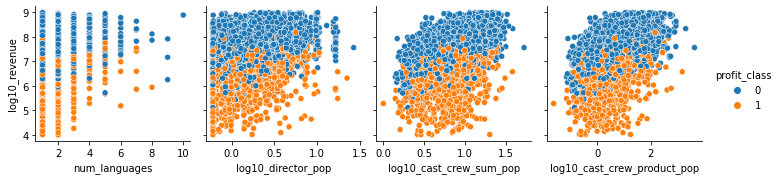

In [32]:
sns.pairplot(
    data=df
    , y_vars = 'log10_revenue'
    , x_vars = ['num_languages', 'log10_director_pop'
                , 'log10_cast_crew_sum_pop', 'log10_cast_crew_product_pop']
    , hue='profit_class'
)

<AxesSubplot:>

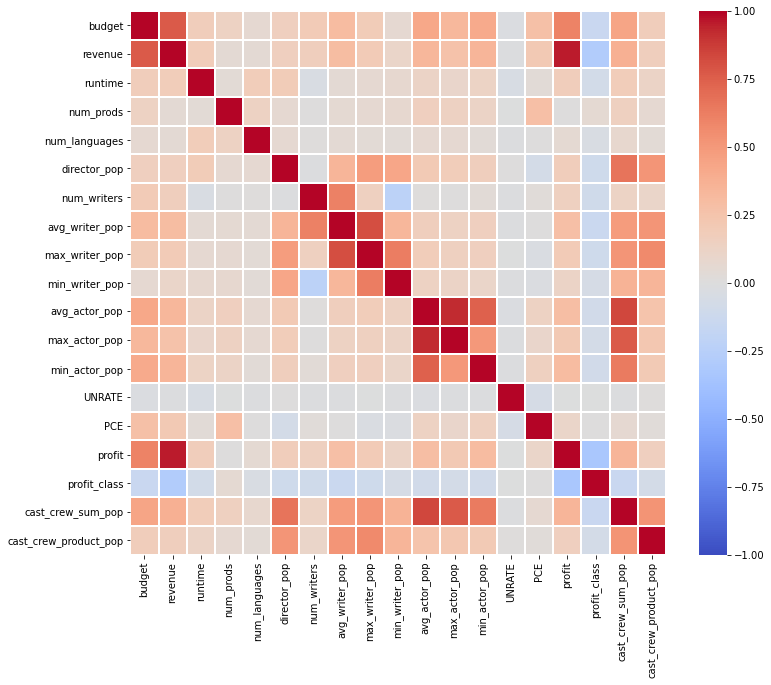

In [139]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), linewidths=1, cmap='coolwarm', vmin=-1, vmax=1)

### 0.4 Principal Component Analysis (PCA)

In [140]:
from sklearn.decomposition import PCA

In [142]:
pca = PCA(n_components=2)
X = df[df.describe().columns]
pca.fit(X)

PCA(n_components=2)

In [145]:
# sns.scatterplot(data=pd.DataFrame(test))
dfPCA = pd.DataFrame(pca.transform(X))
# dfy = pd.DataFrame(y)
# dfPCA = dfPCA.merge(dfy, left_on=dfPCA.index, right_on=dfy.index).drop('key_0', axis=1)
# sns.scatterplot(data=dfPCA)

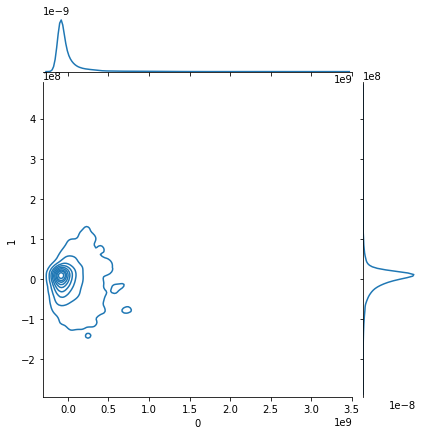

In [148]:
sns.jointplot(x=dfPCA[0], y=dfPCA[1]
              , kind='kde')

<AxesSubplot:xlabel='0', ylabel='Count'>

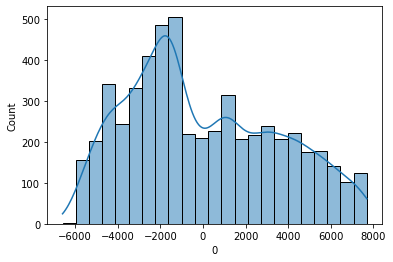

In [147]:
sns.histplot(dfPCA[0], kde=True)
# sns.histplot(dfPCA[1], kde=True)

### 1. Factorise the code into a function to do used in preprocessing

In [103]:
from preprocess_data import load_data
df = load_data()

In [104]:
def preprocess(df):
    """
    Function to preprocess the data ahead of ML
    """
    
    # drop some of the categorical columns
    DROP_COLUMNS = [col for col in df.columns if col[:3]=="lan"]
    df.drop(DROP_COLUMNS, axis=1, inplace=True)
    
    DROP_COLUMNS = [col for col in df.columns if col[:4]=="year"]
    df.drop(DROP_COLUMNS, axis=1, inplace=True)

    # loop through the columns we want to aggregate
    for col_type in [
        "original_language_"
        , "prod_comp_cntry_"
        , "prod_comp_names_"
        , "writers_"
        , "actors_"
        , "genres_"
        , "director_"
    ]:
        # create a dictionary of each unique value and its frequency
        val_freq = {}
        for col in df.columns:
            if col.startswith(col_type):
                val_freq[col] = df[col].sum()

        # create a dataframe from this dictionary; sort by count
        counts = pd.DataFrame.from_dict(
            val_freq
            , orient='index'
            , columns=['count']
        ).sort_values('count', ascending=False)
        counts['frac'] = counts['count'].apply(lambda x: 100*x / df.shape[0])

        # handle special case of production company country
        if col_type == "prod_comp_cntry_":
            DROP_COLUMNS = [col for col in counts.index][3:]

        # handle special case of directors
        elif col_type == "director_":
            DIRECTOR_COLS = [col for col in df.columns
                             if col.startswith("director_")
                             and col!="director_pop"]
            df['established_director'] = df[DIRECTOR_COLS].max(axis=1)
            DROP_COLUMNS = DIRECTOR_COLS

        # handle special case of actors
        elif col_type == "actors_":
            ACTORS_COLS = [col for col in df.columns if "actors" in col]
            df['num_top_100_actors'] = df[ACTORS_COLS].sum(axis=1)
            DROP_COLUMNS = ACTORS_COLS

        # handle all the other cases
        else:
            DROP_COLUMNS = [col for col in counts.query('frac < 2').index]


        df.drop(DROP_COLUMNS, axis=1, inplace=True)
        
        
    ##########################################################################
    # adjust the data for inflation
    CPI_tf = df['CPIAUCSL'].max()
    df['budget'] = df[['budget', 'CPIAUCSL']].apply(
        cpi_adjust
        , args=(CPI_tf ,)
        , axis=1
    )
    df['revenue'] = df[['revenue', 'CPIAUCSL']].apply(
        cpi_adjust
        , args=(CPI_tf ,)
        , axis=1
    )
    # no longer need CPI data
    df.drop('CPIAUCSL', axis=1, inplace=True)
        
    ########################################################################## 
    # add in useful features about the cast and crew
    df['cast_crew_sum_pop'] = (
        df['director_pop'] + df['avg_actor_pop'] + df['avg_writer_pop']
    )
    df['cast_crew_product_pop'] = (
        df['director_pop'] * df['avg_actor_pop'] * df['avg_writer_pop']
    )
    df['runtime'].replace(to_replace=0, value=df['runtime'].median(), inplace=True)
    df = df.query('10000 <= revenue <= 1000000000').copy()
    df = df.query('100000 <= budget').copy()
    df.drop('sum_actor_pop', axis=1, inplace=True)
    df.drop('min_writer_pop', axis=1, inplace=True)

    # code to transform some numerical columns with a logarithm
    for col in [
        "budget", "runtime", "director_pop", "avg_writer_pop"
        , "max_writer_pop", "avg_actor_pop", "max_actor_pop"
        , "min_actor_pop", 'cast_crew_sum_pop'
        , 'cast_crew_product_pop'
    ]:
        df['log10_'+col] = df[col].apply(lambda x: math.log10(x))
        df.drop(col, axis=1, inplace=True)
        
    return df

def cpi_adjust(row, CPI_tf):
    """
    Function to adjust the dollar amounts of previous years by the Consumer
    Price Index.
    
    x_tf = x_ts (CPI_tf / CPI_ts)
    
    Args:
    - row: the row of data sent to the function
    - CPI_tf: most recent CPI
    """
    CPI_ts = row['CPIAUCSL']
    x_ts = row.iloc[0]
    
    x_tf = x_ts * (CPI_ts / CPI_tf)
    return x_tf
    

In [105]:
preprocess(df).head()

,id,original_title,popularity,release_date,revenue,num_prods,num_languages,tmdbId,num_writers,UNRATE,PCE,profit,profit_class,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Fantasy,genres_Drama,genres_Romance,genres_Action,genres_Crime,genres_Thriller,genres_Mystery,genres_Sci-Fi,genres_Musical,genres_Horror,genres_War,genres_IMAX,prod_comp_names_Warner_Bros._Pictures,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_runtime,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
0,862.0,Toy Story,112.136,1995-10-01,2.215460e+08,1,1,862.0,5,5.5,5013.9,343554033.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.250232,1.908485,0.525304,0.652182,0.822822,1.051268,1.429510,0.393048,1.280904,2.228754
1,8844.0,Jumanji,22.333,1995-12-01,1.562650e+08,4,2,8844.0,3,5.6,5097.5,197797249.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.587154,2.017033,0.471732,0.260389,0.629817,0.876776,1.069668,0.318272,1.090399,1.608897
2,31357.0,Waiting to Exhale,6.240,1995-12-01,4.843322e+07,1,1,31357.0,2,5.6,5097.5,65452156.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,6.978361,2.103804,0.725830,-0.175874,0.146438,0.524006,0.754578,0.199206,0.969789,1.073962
3,949.0,Heat,28.870,1995-12-01,1.114540e+08,3,2,949.0,1,5.6,5097.5,127436818.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1.0,7.552392,2.230449,0.962985,0.485863,0.962985,1.037811,1.211307,0.914079,1.364620,2.486659
4,11860.0,Sabrina,11.671,1995-12-01,3.191459e+07,7,2,11860.0,5,5.6,5097.5,-4327920.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1.0,7.537669,2.103804,0.031408,0.337858,0.350829,0.858918,1.054498,0.697142,1.020292,1.228185
